### Task 2.1

Predicted class: airliner


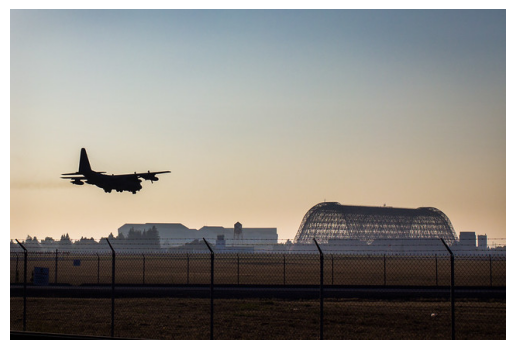

In [ ]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2

# (mostly) From HF Website:
url = 'http://farm4.staticflickr.com/3828/9411256849_e086c73400_z.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.eval()

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

plt.imshow(image)
plt.axis('off')
plt.show()


### Task 2.2+

torch.Size([1, 12, 197, 197])
torch.Size([1, 197, 197])
(196,)
(14, 14)


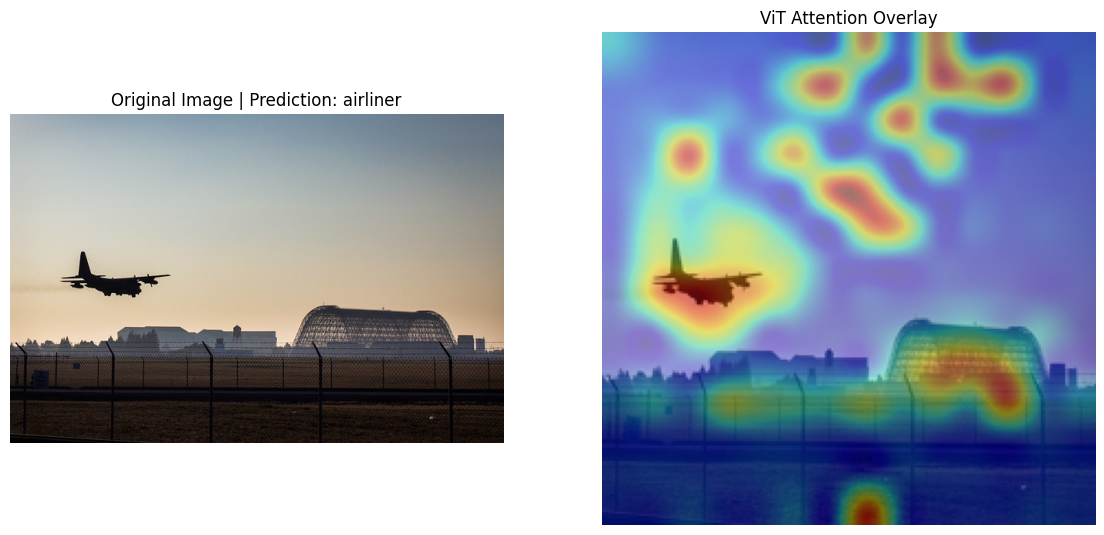

In [39]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_attentions=True)

attn = outputs.attentions[-1]
print (attn.shape)

avg_attention = torch.mean(attn, dim=1)
print (avg_attention.shape)

cls_token = avg_attention[0, 0, 1:].detach().numpy()
print (cls_token.shape)
# 196 -> 14x14

attention_map = cls_token.reshape(14,14) 
print (attention_map.shape)

img_resized = image.resize((224, 224))

heatmap = cv2.resize(attention_map, (img_resized.width, img_resized.height), interpolation=cv2.INTER_CUBIC)
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]

overlayed_image = (np.array(img_resized) / 255.0) * 0.6 + heatmap_colored * 0.4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.imshow(image)
ax1.set_title(f"Original Image | Prediction: {model.config.id2label[predicted_class_idx]}")
ax1.axis("off")

ax2.imshow(overlayed_image)
ax2.set_title("ViT Attention Overlay")
ax2.axis("off")
plt.show()

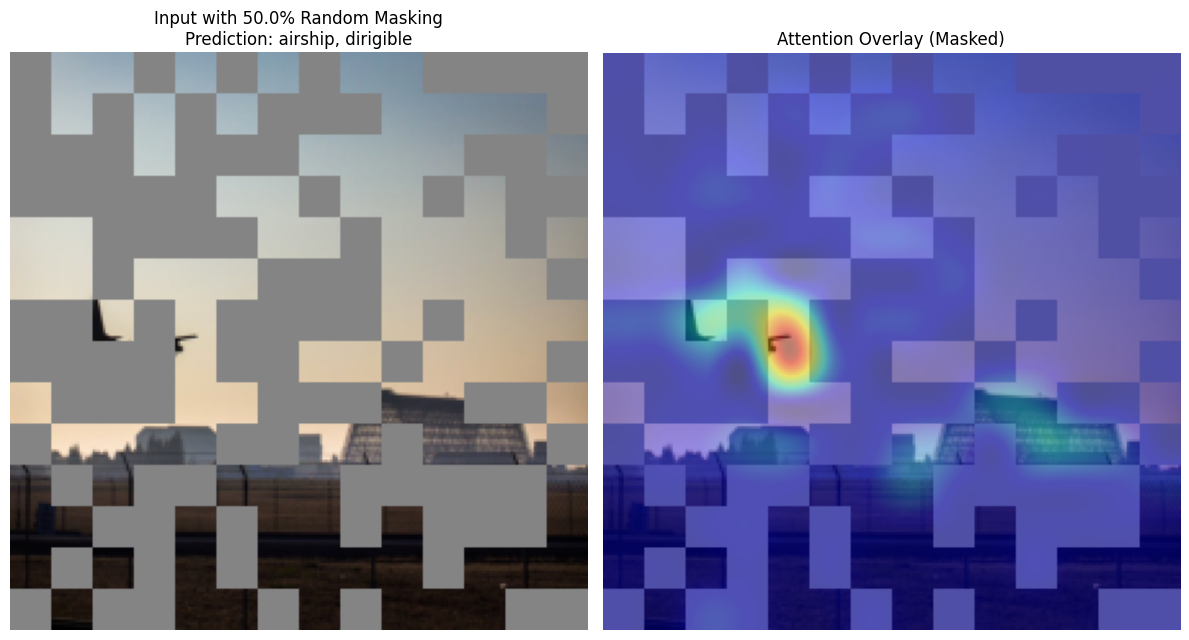

In [ ]:
inputs = processor(images=image, return_tensors="pt")["pixel_values"]

img_size = inputs.shape[-1]

masked_tensor = inputs.clone()
_, _, height, width = masked_tensor.shape
num_patches_h = height // 16
num_patches_w = width // 16
total_patches = num_patches_h * num_patches_w
num_patches_to_mask = int(total_patches * 0.5)

indices_to_mask = torch.randperm(total_patches)[:num_patches_to_mask]
for idx in indices_to_mask:
    patch_row = idx // num_patches_w
    patch_col = idx % num_patches_w
    row_start, col_start = patch_row * 16, patch_col * 16
    masked_tensor[:, :, row_start:row_start + 16, col_start:col_start + 16] = 0.0

with torch.no_grad():
    outputs_masked = model(pixel_values=masked_tensor, output_attentions=True)

logits_masked = outputs_masked.logits
predicted_class_idx_masked = logits_masked.argmax(-1).item()
prediction_label_masked = model.config.id2label[predicted_class_idx_masked]

attn_masked = outputs_masked.attentions[-1]
avg_attention_masked = torch.mean(attn_masked, dim=1)
cls_masked = avg_attention_masked[0, 0, 1:].detach().numpy()
attention_map_masked = cls_masked.reshape(14, 14)

heatmap_masked = cv2.resize(attention_map_masked, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
heatmap_masked = (heatmap_masked - np.min(heatmap_masked)) / (np.max(heatmap_masked) - np.min(heatmap_masked))
heatmap_colored_masked = plt.cm.jet(heatmap_masked)[:, :, :3]

masked_img = masked_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
masked_img = (masked_img - masked_img.min()) / (masked_img.max() - masked_img.min())
overlay_masked = masked_img * (1 - 0.4) + heatmap_colored_masked * 0.4

fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(masked_img)
axes[0].set_title(f"Input with {0.5*100}% Random Masking\nPrediction: {prediction_label_masked}")
axes[0].axis("off")

axes[1].imshow(overlay_masked)
axes[1].set_title("Attention Overlay (Masked)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

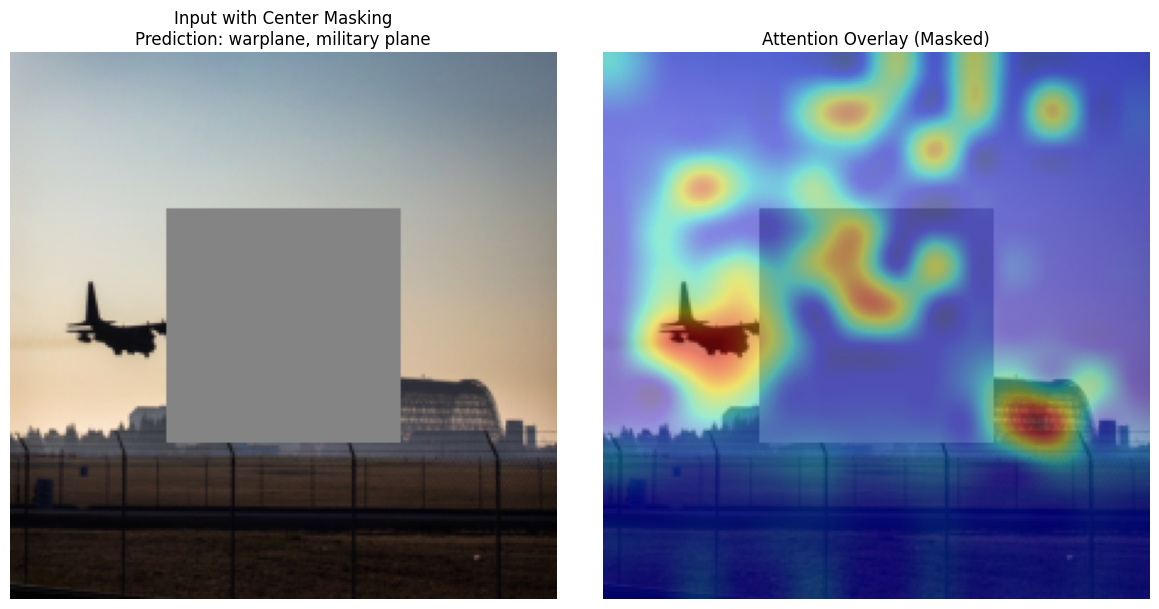

In [ ]:
import math
masked_tensor = inputs.clone()

center_block_size_h = 6
center_block_size_w = 6

start_row_patch = (num_patches_h - center_block_size_h) // 2
start_col_patch = (num_patches_w - center_block_size_w) // 2

row_start_pixel = start_row_patch * 16
row_end_pixel = (start_row_patch + center_block_size_h) * 16
col_start_pixel = start_col_patch * 16
col_end_pixel = (start_col_patch + center_block_size_w) * 16

masked_tensor[:, :, row_start_pixel:row_end_pixel, col_start_pixel:col_end_pixel] = 0.0

with torch.no_grad():
    outputs_masked = model(pixel_values=masked_tensor, output_attentions=True)

logits_masked = outputs_masked.logits
predicted_class_idx_masked = logits_masked.argmax(-1).item()
prediction_label_masked = model.config.id2label[predicted_class_idx_masked]

attn_masked = outputs_masked.attentions[-1]
avg_attention_masked = torch.mean(attn_masked, dim=1)

cls_masked = avg_attention_masked[0, 0, 1:].detach().numpy()
attention_map_masked = cls_masked.reshape(14, 14)

heatmap_masked = cv2.resize(attention_map_masked, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
heatmap_masked = (heatmap_masked - np.min(heatmap_masked)) / (np.max(heatmap_masked) - np.min(heatmap_masked))
heatmap_colored_masked = plt.cm.jet(heatmap_masked)[:, :, :3]

masked_img = masked_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
masked_img = (masked_img - masked_img.min()) / (masked_img.max() - masked_img.min())
overlay_masked = masked_img * (1 - 0.4) + heatmap_colored_masked * 0.4

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(masked_img)
axes[0].set_title(f"Input with Center Masking\nPrediction: {prediction_label_masked}")
axes[0].axis("off")

axes[1].imshow(overlay_masked)
axes[1].set_title("Attention Overlay (Masked)")
axes[1].axis("off")

plt.tight_layout()
plt.show()